Use the model in magnus_objective

In [1]:
import numpy as np
import jax.numpy as jnp

from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')


# set default backend
Array.set_default_backend('jax')

In [2]:
dim = 5 # truncation dimension

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))
ident = np.eye(dim, dtype=complex)

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)

# projection onto levels above the first two
ones = np.ones(dim, dtype=complex)
ones[0:2] = np.array([0., 0.])
P = np.diag(ones)

# model parameters - work in units of GHz/ns
v = 5.0
anharm = -0.33
r = 0.02

In [3]:
from qiskit_dynamics import DiscreteSignal
from discrete_signals import get_param_to_signal

# choose the size of the cheb basis
cheb_order = 8

# choose # steps of the signal
N = 50

# Construct the parameterization given the parameters
param_to_signal = get_param_to_signal(cheb_order, N)
sample_dt = 0.125

# total time of pulse
T = sample_dt * len(param_to_signal(np.random.rand(2, cheb_order + 1)))

In [4]:
X = Array([[0., 1.], [1., 0.]])

def fidelity(V):
    V = Array(V)
    return np.abs((X * V[0:2, 0:2]).sum())**2 / 4

In [37]:
from qiskit_dynamics import Solver, DiscreteSignal, RotatingFrame
from qiskit_dynamics.perturbation import solve_lmde_perturbation, ArrayPolynomial
from qiskit_dynamics.array import Array
from jax import jit

from functools import partial
from jax import jit
from jax.scipy.linalg import expm as jexpm

static_hamiltonian = 2 * np.pi * v * numb + np.pi * anharm * numb * (numb - ident)
drive_hamiltonian = 2 * np.pi * r * osc_X

perturb1 = 2 * np.pi * v * numb
perturb2 = np.pi * anharm * numb * (numb - ident)
perturb3 = 2 * np.pi * r * osc_X
perturb4 = 2 * np.pi * r * osc_X
perturb5 = (np.pi / 3) * anharm * numb * (numb - ident) * (numb - 2 * ident)
perturb6 = 2 * np.pi * r * (P @ osc_X @ P)

hamiltonian_operators = [
    drive_hamiltonian,
    perturb1,
    perturb2,
    perturb3,
    perturb4,
    perturb5,
    perturb6
]

solver = Solver(
    static_hamiltonian=static_hamiltonian,
    hamiltonian_operators=hamiltonian_operators,
    rotating_frame=np.diag(static_hamiltonian)
)


def ode_infidelity(control_params, model_params):
    # construct s(b, t)
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    # extract model parameters and set up solver coefficients
    c1, c2, c3, c4, c5, c6 = model_params

    signals = [
        control_signal,
        Array(c1),
        Array(c2),
        control_signal * Array(c3),
        (control_signal * control_signal) * Array(c4),
        Array(c5),
        control_signal * Array(c6)
    ]
    
    solver_copy = solver.copy()
    solver_copy.signals = signals
    
    results = solver_copy.solve(
        t_span=[0,T], 
        y0=np.eye(dim), 
        atol=1e-10, 
        rtol=1e-10,
        method='jax_odeint'
    )
    
    # return infidelity
    return 1. - fidelity(results.y[-1]).data


rotating_frame = solver.model.rotating_frame

In [9]:
def compute_2d_perturbation_comparison(
    control_params, 
    model_params_dirs,
    perturbations,
    perturb_vals,
    max_magnus_order=5
):
    """
    Args:
        control_params for params to signal
        model_params_dir for 1d direction in model parameter space
        perturbation is the function computing the perturbation in the lab frame
        perturb_vals is the list of values to plot over
        max_magnus_order is the maximum magnus order to compute up to
    """
    (model_params_dir1, model_params_dir2) = model_params_dirs
    (perturbation1,perturbation2) = perturbations
    (perturb_vals1, perturb_vals2) = perturb_vals
    # jit function for computing ode fidelity
    #ode_func = jit(lambda x: ode_infidelity(control_params, x * model_params_dir))
    ode_func = jit(lambda x,y: ode_infidelity(control_params, x * model_params_dir1 + y * model_params_dir2))
    
    # compute perturbation terms
    samples = param_to_signal(control_params)
    control_signal = DiscreteSignal(samples=samples, dt=sample_dt, carrier_freq=v)
    
    def generator(t):
        op = control_signal(t) * (-1j * drive_hamiltonian)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame1(t):
        op = perturbation1(t)
        return rotating_frame.operator_into_frame(t, op)
    
    def perturb_in_frame2(t):
        op = perturbation2(t)
        return rotating_frame.operator_into_frame(t, op)
    
    results = solve_lmde_perturbation(
        perturbations=[perturb_in_frame1, perturb_in_frame2],
        t_span=[0, T],
        expansion_method='magnus',
        expansion_order=max_magnus_order,
        generator=generator,
        integration_method='jax_odeint',
        rtol=1e-10,
        atol=1e-10
    )
    term_labels = results.perturbation_results.expansion_labels
    perturbation_terms = results.perturbation_results.expansion_terms
    
    # construct magnus expansions for each order from results
    magnus_expansions = []
    for order in range(1, max_magnus_order + 1):
        n_terms = list(map(lambda x: len(x) <= order, term_labels)).count(True)
        magnus_expansion = ArrayPolynomial(
            array_coefficients=perturbation_terms[:n_terms, -1],
            monomial_labels=term_labels[:n_terms]
        )
        magnus_expansions.append(magnus_expansion)
    
    U = results.y[-1]

    # get the approximate error rates using the Magnus terms
    @partial(jit, static_argnums=(2,))
    def err_est(c1, c2, order):

        coeffs = jnp.array([c1, c2])

        U_approx = U @ jexpm(magnus_expansions[order - 1](coeffs).data)

        return 1. - fidelity(U_approx).data
    
    ode_vals = []
    magnus_vals = [[] for _ in range(max_magnus_order)]
    for val1 in perturb_vals1:
        for val2 in perturb_vals2:
            ode_vals.append(ode_func(val1,val2))
        
            for order, magnus_val in enumerate(magnus_vals):
                magnus_val.append(err_est(val1, val2, order + 1))
    
    return ode_vals, magnus_vals

In [38]:
rand_control_params = 10. * np.random.rand(2, cheb_order + 1)

In [39]:
perturb1_vals = jnp.linspace(-0.007, 0.007, 21)
perturb2_vals = jnp.linspace(-0.2, 0.2, 21)

perturb1_2_results = compute_2d_perturbation_comparison(
    rand_control_params,
    (jnp.array([1., 0., 0., 0., 0., 0.]),jnp.array([0., 1., 0., 0., 0., 0.])),
    (lambda t: -1j * perturb1, lambda t: -1j * perturb2), 
    perturb_vals= (perturb1_vals, perturb2_vals),
    max_magnus_order=5
)

In [41]:
# helper function for 2D meshplots
def cell_centered(arr_in):
    arr_out = np.empty(len(arr_in)+1)
    dist = arr_in[1] - arr_in[0]
    for i in range(len(arr_in)):
        arr_out[i] = arr_in[i] - dist/2
    arr_out[-1] = arr_in[-1] + dist/2
    return arr_out

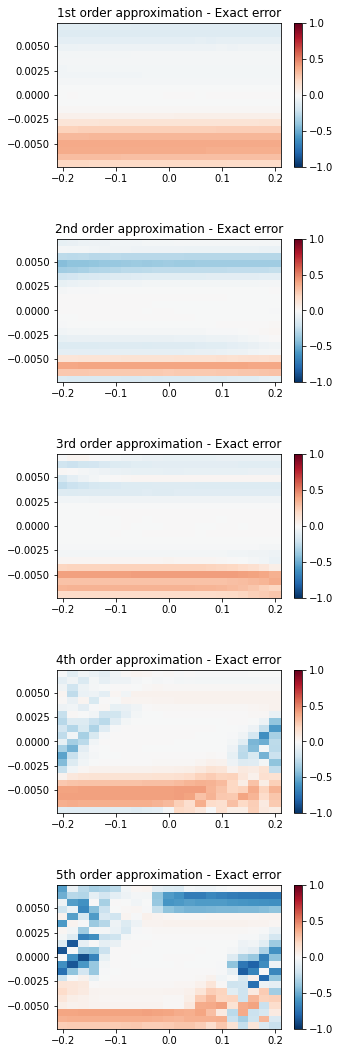

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

#plot the differences between estimates and exact error
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5)
diff1 = jnp.array(perturb1_2_results[1][0]) - jnp.array(perturb1_2_results[0])
diff2 = jnp.array(perturb1_2_results[1][1]) - jnp.array(perturb1_2_results[0])
diff3 = jnp.array(perturb1_2_results[1][2]) - jnp.array(perturb1_2_results[0])
diff4 = jnp.array(perturb1_2_results[1][3]) - jnp.array(perturb1_2_results[0])
diff5 = jnp.array(perturb1_2_results[1][4]) - jnp.array(perturb1_2_results[0])

x_cell = cell_centered(perturb2_vals)
y_cell = cell_centered(perturb1_vals)
cb_min = -1
cb_max = 1

im1 = ax1.pcolormesh(x_cell, y_cell, diff1.reshape(len(perturb1_vals),len(perturb2_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im2 = ax2.pcolormesh(x_cell, y_cell, diff2.reshape(len(perturb1_vals),len(perturb2_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im3 = ax3.pcolormesh(x_cell, y_cell, diff3.reshape(len(perturb1_vals),len(perturb2_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im4 = ax4.pcolormesh(x_cell, y_cell, diff4.reshape(len(perturb1_vals),len(perturb2_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
im5 = ax5.pcolormesh(x_cell, y_cell, diff5.reshape(len(perturb1_vals),len(perturb2_vals)),
                     vmin=cb_min, vmax=cb_max,
                     #norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),
                     cmap='RdBu_r')
#ax0.title.set_text('Exact error')
ax1.title.set_text('1st order approximation - Exact error')
ax2.title.set_text('2nd order approximation - Exact error')
ax3.title.set_text('3rd order approximation - Exact error')
ax4.title.set_text('4th order approximation - Exact error')
ax5.title.set_text('5th order approximation - Exact error')
#fig.colorbar(im0, ax=ax0)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)
fig.colorbar(im5, ax=ax5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
fig.set_size_inches(5, 18.5) #change these numbers to adjust the plots
plt.show()